In [1]:
import os
os.chdir('/content/drive/My Drive/Pytorch/Multiclass classification of news')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Pytorch/Multiclass classification of news'

# Multi-Class Text Classification: Classifying News into various categories

There are lots of applications of text classification in the commercial world. For example, news stories are typically organized by topics; content or products are often tagged by categories; users can be classified into cohorts based on how they talk about a product or brand online.

I have used Python and Jupyter Notebook to develop the classifier, relying on Scikit-Learn for the machine learning components.

We are gonna be using the BBC News dataset that has 5 categories('business', 'tech', 'politics', 'sport', 'entertainment').

Given a new news article that comes in, we need to assign it to one of 5 categories. The classifier makes the assumption that each new news article is assigned to one and only one category. This is multi-class text classification problem.

**Necessary Dependancies**

In [2]:
# for math operations
import pandas as pd
import numpy as np

# for progress bar
from tqdm import tqdm

# for data preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. DATA EXPLORATION

Before diving into training machine learning models, we should look at a few samples of the data pertaining to the different categories:

**Load the Data**

In [3]:
train_file_path = 'BBC News Train.csv'

In [16]:
train = pd.read_csv(train_file_path)
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
train.shape

(1490, 3)

In [17]:
train = train[['Text','Category']]

Following are all the classes of the label:

In [7]:
train.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

We can see that there are 5 different news articles categories.

0       worldcom ex-boss launches defence lawyers defe...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens in ...
3       lifestyle  governs mobile choice  faster  bett...
4       enron bosses in $168m payout eighteen former e...
                              ...                        
1485    double eviction from big brother model caprice...
1486    dj double act revamp chart show dj duo jk and ...
1487    weak dollar hits reuters revenues at media gro...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands of ...
Name: Text, Length: 1490, dtype: object

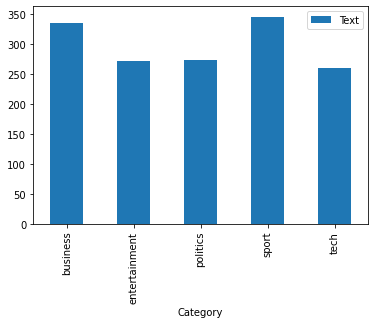

In [18]:
train.groupby('Category').count().plot.bar(ylim=0)
# plt.show()

train['Text']

## 2. Text Preprocessing

There are three major steps in preprocessing:

* First, we gotta remove the punctuation, numbers, and stop words from each news article.
* second, all the words are converted to lower case and then stemmed using the Porter Stemmer in the NLTK package. The goal of stemming is to reduce the number of forms of words appearing in the article; it will cause words such as “performance” and “performing” to syntactically match one another by reducing them to their base word “perform”. This helps decrease the size of the vocabulary space and improve the volume of the feature space in the corpus.
* Finally, each corpus is transformed into vector space model (VSM) using the TF-IDF vectorizer in Python’s SKlearn package to extract the features.

In [19]:
stemmer = PorterStemmer()
words = stopwords.words("english")

train['Text'] = train['Text'].apply(
    lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

worldcom ex boss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic us telecom giant warn led collaps firm follow discoveri bn bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan mention anyth uncomfo

After preprocessing text..

In [12]:
# train.head()
train

,Text,Category
0,worldcom ex boss launch defenc lawyer defend f...,business
1,german busi confid slide german busi confid fe...,business
2,bbc poll indic econom gloom citizen major nati...,business
3,lifestyl govern mobil choic faster better funk...,tech
4,enron boss payout eighteen former enron direct...,business
...,...,...
1485,doubl evict big brother model capric holbi cit...,entertainment
1486,dj doubl act revamp chart show dj duo jk joel ...,entertainment
1487,weak dollar hit reuter revenu media group reut...,business
1488,appl ipod famili expand market appl expand ipo...,tech



**Feature Extraction**

In [20]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(train['Text']).toarray()
final_features.shape

(1490, 19691)

In [46]:
len(vectorizer.get_feature_names_out())

18650

so we ended up with 18650 features after converting the text into vectors. now we proceed with building our model and fit the model with our data.

## 3. Model Building 

When dealing with very long vectors, sometimes it might be better to select your best features instead of using all of them. To do so, we use the **SelectKbest method from SKlearn.feature_selection package** we then we use the **Chi2 score** that can be used to select the n_features features with the highest values for the test chi-squared. 

In [46]:
#first we split our dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X = train['Text']
Y = train['Category']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# instead of doing these steps one at a time, we can use a pipeline to complete them all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

## 4. Evaluation of the Model

In [47]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

               precision    recall  f1-score   support

     business       0.97      0.93      0.95        68
entertainment       0.98      0.98      0.98        49
     politics       0.95      0.98      0.97        60
        sport       1.00      1.00      1.00        65
         tech       0.95      0.96      0.96        56

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298

[[63  0  2  0  3]
 [ 0 48  1  0  0]
 [ 0  1 59  0  0]
 [ 0  0  0 65  0]
 [ 2  0  0  0 54]]


Text(0.5, 1.0, 'Confusion Matrix')

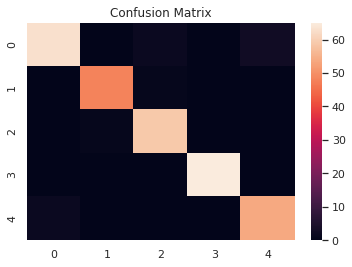

In [49]:
import seaborn as sns; sns.set()
ax = sns.heatmap(confusion_matrix(ytest, model.predict(X_test)))
plt.title('Confusion Matrix')

From the results it is evident that the model fits really well not only to the training data but also the validation set with **0.97 precision and recall**.